# Data Lab

A temporary Notebook where I can test out ideas.

In [1]:
path_to_owl = "../ontodesigner/archive/ppeo/PPEO.owl"

with open(path_to_owl, "r") as f:
    owl_content = f.read()
    
print(owl_content)

<?xml version="1.0"?>
<rdf:RDF xmlns="http://purl.org/ppeo/PPEO.owl#"
     xml:base="http://purl.org/ppeo/PPEO.owl"
     xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
     xmlns:owl="http://www.w3.org/2002/07/owl#"
     xmlns:xml="http://www.w3.org/XML/1998/namespace"
     xmlns:xsd="http://www.w3.org/2001/XMLSchema#"
     xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#"
     xmlns:dc="http://purl.org/dc/elements/1.1/"
     xmlns:PPEO="http://purl.org/ppeo/PPEO.owl#">
    <owl:Ontology rdf:about="http://purl.org/ppeo/PPEO.owl">
        <dc:creator rdf:datatype="http://www.w3.org/2001/XMLSchema#string">Bruno Vasques Costa</dc:creator>
        <dc:creator rdf:datatype="http://www.w3.org/2001/XMLSchema#string">Cyril Pommier</dc:creator>
        <dc:creator rdf:datatype="http://www.w3.org/2001/XMLSchema#string">Daniel Faria</dc:creator>
        <dc:creator rdf:datatype="http://www.w3.org/2001/XMLSchema#string">Evangelia Papoutsoglou</dc:creator>
        <dc:creator rdf:datatype

In [6]:
#!/usr/bin/env python3
"""
Simple OWL to JSON-LD Converter

A more straightforward converter that focuses on key elements.
"""

import json
import xml.etree.ElementTree as ET
import re
from collections import defaultdict

def parse_owl_to_jsonld(owl_file_path, output_file=None):
    """
    Parse OWL file and convert to JSON-LD context format.
    """
    print(f"Reading OWL file: {owl_file_path}")
    
    try:
        tree = ET.parse(owl_file_path)
        root = tree.getroot()
    except Exception as e:
        print(f"Error reading file: {e}")
        return None
    
    # Register namespaces
    namespaces = {
        'rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#',
        'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
        'owl': 'http://www.w3.org/2002/07/owl#',
        'xml': 'http://www.w3.org/XML/1998/namespace',
    }
    
    for prefix, uri in namespaces.items():
        ET.register_namespace(prefix, uri)
    
    # Extract ontology info
    ontology_uri = None
    for ontology in root.findall('.//owl:Ontology', namespaces):
        ontology_uri = ontology.get('{%s}about' % namespaces['rdf'])
        break
    
    if not ontology_uri:
        # Try to get from xmlns
        for attr, value in root.attrib.items():
            if 'xmlns' in attr and not attr.endswith(':'):
                ontology_uri = value
                break
    
    # Determine ontology prefix
    ontology_prefix = "PPEO"
    if ontology_uri:
        # Extract short name
        if '#' in ontology_uri:
            ontology_prefix = ontology_uri.split('#')[-1]
        elif '/' in ontology_uri:
            ontology_prefix = ontology_uri.rstrip('/').split('/')[-1]
    
    # Collect all terms
    classes = {}
    object_properties = {}
    datatype_properties = {}
    annotation_properties = {}
    individuals = {}
    
    # Helper function to get label
    def get_label(element):
        for label in element.findall('.//rdfs:label', namespaces):
            return label.text
        # Try to get from rdf:about
        about = element.get('{%s}about' % namespaces['rdf'])
        if about:
            if '#' in about:
                return about.split('#')[-1]
            elif '/' in about:
                return about.split('/')[-1]
        return None
    
    # Helper function to get comment/definition
    def get_comment(element):
        for comment in element.findall('.//rdfs:comment', namespaces):
            return comment.text
        return None
    
    # Parse classes
    for cls in root.findall('.//owl:Class', namespaces):
        about = cls.get('{%s}about' % namespaces['rdf'])
        if about:
            short_name = about.split('#')[-1] if '#' in about else about.split('/')[-1]
            classes[short_name] = {
                "@id": f"{ontology_prefix}:{short_name}",
                "type": "Class",
                "label": get_label(cls),
                "definition": get_comment(cls)
            }
    
    # Parse object properties
    for prop in root.findall('.//owl:ObjectProperty', namespaces):
        about = prop.get('{%s}about' % namespaces['rdf'])
        if about:
            short_name = about.split('#')[-1] if '#' in about else about.split('/')[-1]
            object_properties[short_name] = {
                "@id": f"{ontology_prefix}:{short_name}",
                "type": "ObjectProperty",
                "label": get_label(prop),
                "definition": get_comment(prop)
            }
            
            # Get domain and range if available
            domain = prop.find('.//rdfs:domain', namespaces)
            if domain is not None:
                domain_resource = domain.get('{%s}resource' % namespaces['rdf'])
                if domain_resource:
                    object_properties[short_name]["domain"] = domain_resource.split('#')[-1] if '#' in domain_resource else domain_resource.split('/')[-1]
            
            range_elem = prop.find('.//rdfs:range', namespaces)
            if range_elem is not None:
                range_resource = range_elem.get('{%s}resource' % namespaces['rdf'])
                if range_resource:
                    object_properties[short_name]["range"] = range_resource.split('#')[-1] if '#' in range_resource else range_resource.split('/')[-1]
    
    # Parse datatype properties
    for prop in root.findall('.//owl:DatatypeProperty', namespaces):
        about = prop.get('{%s}about' % namespaces['rdf'])
        if about:
            short_name = about.split('#')[-1] if '#' in about else about.split('/')[-1]
            datatype_properties[short_name] = {
                "@id": f"{ontology_prefix}:{short_name}",
                "type": "DatatypeProperty",
                "label": get_label(prop),
                "definition": get_comment(prop)
            }
    
    # Parse annotation properties
    for prop in root.findall('.//owl:AnnotationProperty', namespaces):
        about = prop.get('{%s}about' % namespaces['rdf'])
        if about:
            short_name = about.split('#')[-1] if '#' in about else about.split('/')[-1]
            annotation_properties[short_name] = {
                "@id": f"{ontology_prefix}:{short_name}",
                "type": "AnnotationProperty",
                "label": get_label(prop)
            }
    
    # Parse individuals
    for indiv in root.findall('.//owl:NamedIndividual', namespaces):
        about = indiv.get('{%s}about' % namespaces['rdf'])
        if about:
            short_name = about.split('#')[-1] if '#' in about else about.split('/')[-1]
            individuals[short_name] = {
                "@id": f"{ontology_prefix}:{short_name}",
                "type": "Individual",
                "label": get_label(indiv),
                "definition": get_comment(indiv)
            }
    
    # Build context
    context = {
        "schema": "https://schema.org/",
        "rdf": namespaces['rdf'],
        "rdfs": namespaces['rdfs'],
        "owl": namespaces['owl'],
        "xsd": "http://www.w3.org/2001/XMLSchema#",
        ontology_prefix: ontology_uri + "#"
    }
    
    # Build ontology structure
    ontology_data = {
        "namespace": ontology_uri or "",
        "description": ontology_prefix,
        "version": "1.0",
        "imports": [],
        "classes": classes,
        "objectProperties": object_properties,
        "datatypeProperties": datatype_properties,
        "annotationProperties": annotation_properties,
        "individuals": individuals
    }
    
    # Build quick context
    quick_context = {}
    for term_dict, terms in [
        (classes, "Class"),
        (object_properties, "ObjectProperty"),
        (datatype_properties, "DatatypeProperty"),
        (annotation_properties, "AnnotationProperty"),
        (individuals, "Individual")
    ]:
        for term_name in term_dict:
            quick_context[term_name] = f"{ontology_prefix}:{term_name}"
    
    # Final result
    result = {
        "@context": context,
        "ontologies": {
            ontology_prefix: ontology_data
        },
        "quickContext": quick_context
    }
    
    # Save to file if specified
    if output_file:
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(result, f, indent=2, ensure_ascii=False)
        print(f"Saved to: {output_file}")
    
    return result

def main():
    
    
    owl_file = path_to_owl
    output_file = 'test.jsonld'

    
    result = parse_owl_to_jsonld(owl_file, output_file)
    
    if result:
        print(f"Successfully parsed {owl_file}")
        print(f"Found: {len(result['ontologies']['PPEO.owl']['classes'])} classes")
        print(f"Found: {len(result['ontologies']['PPEO.owl']['objectProperties'])} object properties")
        print(f"Found: {len(result['ontologies']['PPEO.owl']['datatypeProperties'])} datatype properties")
        print(f"Found: {len(result['ontologies']['PPEO.owl']['individuals'])} individuals")

if __name__ == "__main__":
    main()

Reading OWL file: ../ontodesigner/archive/ppeo/PPEO.owl
Saved to: test.jsonld
Successfully parsed ../ontodesigner/archive/ppeo/PPEO.owl
Found: 31 classes
Found: 38 object properties
Found: 49 datatype properties
Found: 11 individuals


=== Graph Information ===
Number of nodes: 6
Number of edges: 4

=== Node Types ===
  Observation: 1 nodes
  Place: 2 nodes
  Property: 1 nodes
  QuantitativeValue: 1 nodes
  Sensor: 1 nodes

=== Relationships (Edges) ===
  measuredBy: 1 relationships
  measuredProperty: 1 relationships
  measuredValue: 1 relationships
  observedNode: 1 relationships

=== Sample Nodes ===
  Node 1: earth [Place]
  Node 2: 358 [Observation]
  Node 3: location of VCAB-DP1-BP-40 [Place]
  Node 4: the ground displacement speed at location of VCAB-DP1-BP-40 [Property]
  Node 5: seismograph VCAB DP1 BP 40 (Vineyard Canyon, Parkfield, Ca) [Sensor]


TypeError: RegularPolygon.__init__() takes 3 positional arguments but 4 were given

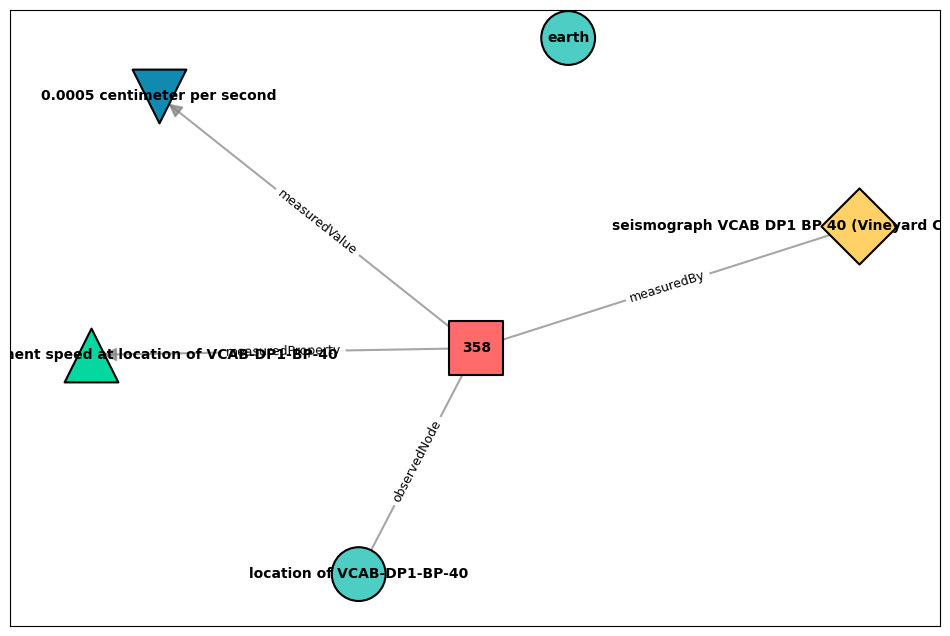

In [9]:
#!/usr/bin/env python3
"""
JSON-LD Graph Visualizer for Measurement Data

Visualizes JSON-LD measurement data as a graph with different node types
and relationships.
"""

import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import matplotlib.patches as mpatches
from typing import Dict, List, Any, Optional
import numpy as np

class JSONLDGraphVisualizer:
    """Visualize JSON-LD measurement data as a graph."""
    
    def __init__(self, jsonld_data: Dict[str, Any]):
        """
        Initialize with JSON-LD data.
        
        Args:
            jsonld_data: Dictionary containing JSON-LD data
        """
        self.jsonld_data = jsonld_data
        self.graph = nx.DiGraph()
        self.node_colors = {}
        self.node_labels = {}
        self.node_types = {}
        
        # Color scheme for different node types
        self.type_colors = {
            'Observation': '#FF6B6B',  # Red
            'QuantitativeObservation': '#FF6B6B',
            'Place': '#4ECDC4',  # Teal
            'Sensor': '#FFD166',  # Yellow
            'Property': '#06D6A0',  # Green
            'QuantitativeValue': '#118AB2',  # Blue
            'GeoCoordinates': '#073B4C',  # Dark blue
            'default': '#999999'  # Gray
        }
        
        # Node shapes for different types
        self.type_shapes = {
            'Observation': 's',  # Square
            'QuantitativeObservation': 's',
            'Place': 'o',  # Circle
            'Sensor': 'D',  # Diamond
            'Property': '^',  # Triangle up
            'QuantitativeValue': 'v',  # Triangle down
            'GeoCoordinates': 'h',  # Hexagon
            'default': 'o'
        }
        
    def _extract_id(self, item: Any) -> str:
        """Extract ID from JSON-LD item."""
        if isinstance(item, dict):
            return item.get('@id', str(id(item)))
        return str(item)
    
    def _extract_types(self, item: Any) -> List[str]:
        """Extract type(s) from JSON-LD item."""
        if isinstance(item, dict):
            types = item.get('@type', [])
            if isinstance(types, str):
                return [types]
            elif isinstance(types, list):
                return types
        return ['Unknown']
    
    def _extract_label(self, item: Any) -> str:
        """Extract a label for a node."""
        if isinstance(item, dict):
            # Try different possible label fields
            for field in ['name', 'label', 'identifier', '@id']:
                if field in item and item[field]:
                    label = str(item[field])
                    # Shorten long IDs
                    if field == '@id' and len(label) > 20:
                        label = label.split('/')[-1].split('#')[-1]
                    return label
            
            # For specific types, extract meaningful labels
            types = self._extract_types(item)
            if 'GeoCoordinates' in types:
                lat = item.get('latitude', '?')
                lon = item.get('longitude', '?')
                return f"Geo({lat}, {lon})"
            elif 'QuantitativeValue' in types:
                value = item.get('value', '?')
                unit = item.get('unitText', item.get('unitCode', ''))
                return f"{value} {unit}"
            
        return str(item)
    
    def _get_node_color(self, types: List[str]) -> str:
        """Get color for node based on its types."""
        for t in types:
            if t in self.type_colors:
                return self.type_colors[t]
        return self.type_colors['default']
    
    def _get_node_shape(self, types: List[str]) -> str:
        """Get shape for node based on its types."""
        for t in types:
            if t in self.type_shapes:
                return self.type_shapes[t]
        return self.type_shapes['default']
    
    def _add_node(self, node_id: str, item: Dict[str, Any]):
        """Add a node to the graph."""
        types = self._extract_types(item)
        label = self._extract_label(item)
        color = self._get_node_color(types)
        shape = self._get_node_shape(types)
        
        # Use primary type for categorization
        primary_type = types[0] if types else 'Unknown'
        
        self.graph.add_node(node_id)
        self.node_colors[node_id] = color
        self.node_labels[node_id] = label
        self.node_types[node_id] = primary_type
        
        # Store additional attributes
        self.graph.nodes[node_id]['label'] = label
        self.graph.nodes[node_id]['type'] = primary_type
        self.graph.nodes[node_id]['types'] = types
        self.graph.nodes[node_id]['color'] = color
        self.graph.nodes[node_id]['shape'] = shape
        
        # Store all data as node attribute
        self.graph.nodes[node_id]['data'] = item
    
    def _add_relationship(self, source_id: str, target_id: str, relationship: str):
        """Add a relationship edge to the graph."""
        self.graph.add_edge(source_id, target_id, label=relationship)
    
    def _process_item(self, item: Dict[str, Any], parent_id: Optional[str] = None, 
                     relationship: Optional[str] = None):
        """Process a JSON-LD item recursively."""
        if not isinstance(item, dict):
            return
        
        item_id = self._extract_id(item)
        
        # Add node if not already added
        if item_id not in self.graph:
            self._add_node(item_id, item)
        
        # Add relationship to parent if exists
        if parent_id and relationship:
            self._add_relationship(parent_id, item_id, relationship)
        
        # Process relationships in the item
        for key, value in item.items():
            # Skip metadata fields
            if key in ['@id', '@type', '@context']:
                continue
            
            # Handle nested objects
            if isinstance(value, dict):
                # Check if it's a reference or nested object
                if '@id' in value:
                    # It's a reference to another node
                    target_id = self._extract_id(value)
                    if target_id not in self.graph:
                        # Add the referenced node with minimal info
                        self._add_node(target_id, value)
                    self._add_relationship(item_id, target_id, key)
                else:
                    # It's a nested object (like geo coordinates)
                    nested_id = f"{item_id}_{key}"
                    self._process_item(value, item_id, key)
            
            # Handle arrays
            elif isinstance(value, list):
                for i, elem in enumerate(value):
                    if isinstance(elem, dict):
                        elem_id = self._extract_id(elem)
                        if '@id' in elem:
                            # Reference to another node
                            if elem_id not in self.graph:
                                self._add_node(elem_id, elem)
                            self._add_relationship(item_id, elem_id, key)
                        else:
                            # Nested object in array
                            nested_id = f"{item_id}_{key}_{i}"
                            self._process_item(elem, item_id, key)
    
    def build_graph(self):
        """Build the graph from JSON-LD data."""
        # Get the graph data
        graph_data = self.jsonld_data.get('@graph', [])
        
        if not graph_data:
            # If no @graph, try to use the whole structure
            graph_data = [self.jsonld_data]
        
        # Process each item in the graph
        for item in graph_data:
            self._process_item(item)
        
        return self.graph
    
    def visualize(self, output_file: Optional[str] = None, 
                  layout: str = 'spring', show_legend: bool = True,
                  figsize: tuple = (14, 10)):
        """
        Visualize the graph.
        
        Args:
            output_file: Path to save the visualization (optional)
            layout: Layout algorithm ('spring', 'circular', 'kamada_kawai', 'planar')
            show_legend: Whether to show a legend
            figsize: Figure size
        """
        if not self.graph.nodes():
            print("Graph is empty. Did you call build_graph()?")
            return
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Choose layout
        if layout == 'spring':
            pos = nx.spring_layout(self.graph, k=2, iterations=50, seed=42)
        elif layout == 'circular':
            pos = nx.circular_layout(self.graph)
        elif layout == 'kamada_kawai':
            pos = nx.kamada_kawai_layout(self.graph)
        elif layout == 'planar':
            pos = nx.planar_layout(self.graph)
        else:
            pos = nx.spring_layout(self.graph, seed=42)
        
        # Draw nodes by type to get different shapes
        node_shapes = set(self.graph.nodes[n].get('shape', 'o') for n in self.graph.nodes())
        
        for shape in node_shapes:
            nodes_with_shape = [n for n in self.graph.nodes() 
                              if self.graph.nodes[n].get('shape', 'o') == shape]
            
            if nodes_with_shape:
                # Get colors for these nodes
                node_colors = [self.graph.nodes[n]['color'] for n in nodes_with_shape]
                
                # Draw nodes
                nx.draw_networkx_nodes(
                    self.graph, pos,
                    nodelist=nodes_with_shape,
                    node_color=node_colors,
                    node_shape=shape,
                    node_size=1500,
                    edgecolors='black',
                    linewidths=1.5,
                    ax=ax
                )
        
        # Draw edges
        nx.draw_networkx_edges(
            self.graph, pos,
            width=1.5,
            alpha=0.7,
            edge_color='gray',
            arrows=True,
            arrowsize=20,
            ax=ax
        )
        
        # Draw edge labels
        edge_labels = nx.get_edge_attributes(self.graph, 'label')
        nx.draw_networkx_edge_labels(
            self.graph, pos,
            edge_labels=edge_labels,
            font_size=9,
            ax=ax
        )
        
        # Draw node labels
        node_labels = {n: self.graph.nodes[n]['label'] for n in self.graph.nodes()}
        nx.draw_networkx_labels(
            self.graph, pos,
            labels=node_labels,
            font_size=10,
            font_weight='bold',
            ax=ax
        )
        
        # Create legend
        if show_legend:
            legend_patches = []
            type_counts = {}
            
            # Count nodes by type
            for n in self.graph.nodes():
                node_type = self.graph.nodes[n]['type']
                type_counts[node_type] = type_counts.get(node_type, 0) + 1
            
            # Create legend entries for each type
            for node_type, color in self.type_colors.items():
                if node_type != 'default' and node_type in type_counts:
                    count = type_counts.get(node_type, 0)
                    shape = self.type_shapes.get(node_type, 'o')
                    
                    # Create proxy artist
                    if shape == 'o':
                        patch = mpatches.Patch(color=color, label=f'{node_type} ({count})')
                    elif shape == 's':
                        patch = mpatches.Rectangle((0, 0), 1, 1, color=color, label=f'{node_type} ({count})')
                    elif shape == 'D':
                        patch = mpatches.RegularPolygon((0, 0), 4, 0.5, color=color, label=f'{node_type} ({count})')
                    elif shape == '^':
                        patch = mpatches.RegularPolygon((0, 0), 3, 0.5, color=color, orientation=np.pi, label=f'{node_type} ({count})')
                    elif shape == 'v':
                        patch = mpatches.RegularPolygon((0, 0), 3, 0.5, color=color, label=f'{node_type} ({count})')
                    elif shape == 'h':
                        patch = mpatches.RegularPolygon((0, 0), 6, 0.5, color=color, label=f'{node_type} ({count})')
                    else:
                        patch = mpatches.Patch(color=color, label=f'{node_type} ({count})')
                    
                    legend_patches.append(patch)
            
            # Add legend
            ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.05, 1))
        
        # Set title
        ax.set_title('JSON-LD Measurement Graph Visualization', fontsize=16, fontweight='bold', pad=20)
        
        # Remove axes
        ax.axis('off')
        
        # Adjust layout
        plt.tight_layout()
        
        # Save or show
        if output_file:
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            print(f"Graph saved to: {output_file}")
        
        plt.show()
    
    def print_graph_info(self):
        """Print information about the graph."""
        print("=== Graph Information ===")
        print(f"Number of nodes: {self.graph.number_of_nodes()}")
        print(f"Number of edges: {self.graph.number_of_edges()}")
        
        print("\n=== Node Types ===")
        type_counts = {}
        for n in self.graph.nodes():
            node_type = self.graph.nodes[n]['type']
            type_counts[node_type] = type_counts.get(node_type, 0) + 1
        
        for node_type, count in sorted(type_counts.items()):
            print(f"  {node_type}: {count} nodes")
        
        print("\n=== Relationships (Edges) ===")
        edge_labels = nx.get_edge_attributes(self.graph, 'label')
        relationship_counts = {}
        for label in edge_labels.values():
            relationship_counts[label] = relationship_counts.get(label, 0) + 1
        
        for rel, count in sorted(relationship_counts.items()):
            print(f"  {rel}: {count} relationships")
        
        print("\n=== Sample Nodes ===")
        for i, node in enumerate(list(self.graph.nodes())[:5]):
            node_data = self.graph.nodes[node]
            print(f"  Node {i+1}: {node_data['label']} [{node_data['type']}]")
    
    def export_graphml(self, output_file: str):
        """Export graph to GraphML format for use in other tools."""
        nx.write_graphml(self.graph, output_file)
        print(f"Graph exported to GraphML: {output_file}")

def visualize_jsonld_file(jsonld_file: str, output_image: Optional[str] = None):
    """Convenience function to visualize JSON-LD from a file."""
    # Load JSON-LD data
    with open(jsonld_file, 'r') as f:
        data = json.load(f)
    
    # Create visualizer
    visualizer = JSONLDGraphVisualizer(data)
    
    # Build graph
    visualizer.build_graph()
    
    # Print info
    visualizer.print_graph_info()
    
    # Visualize
    visualizer.visualize(output_file=output_image)
    
    # Optionally export to GraphML
    if output_image:
        graphml_file = output_image.replace('.png', '.graphml').replace('.jpg', '.graphml')
        visualizer.export_graphml(graphml_file)
    
    return visualizer

# Example usage with interactive features
def main():
    """Main function with example usage."""
    import argparse
    
    parser = argparse.ArgumentParser(description='Visualize JSON-LD measurement data as a graph')
    parser.add_argument('input_file', help='Path to JSON-LD file')
    parser.add_argument('-o', '--output', help='Output image file (optional)')
    parser.add_argument('--layout', choices=['spring', 'circular', 'kamada_kawai', 'planar'],
                       default='spring', help='Layout algorithm')
    parser.add_argument('--no-legend', action='store_true', help='Hide legend')
    parser.add_argument('--export-graphml', action='store_true', help='Export to GraphML format')
    
    args = parser.parse_args()
    
    # Load data
    try:
        with open(args.input_file, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error loading JSON-LD file: {e}")
        return
    
    # Create visualizer
    visualizer = JSONLDGraphVisualizer(data)
    
    # Build graph
    visualizer.build_graph()
    
    # Print information
    visualizer.print_graph_info()
    
    # Visualize
    visualizer.visualize(
        output_file=args.output,
        layout=args.layout,
        show_legend=not args.no_legend
    )
    
    # Export to GraphML if requested
    if args.export_graphml and args.output:
        graphml_file = args.output.replace('.png', '.graphml').replace('.jpg', '.graphml')
        visualizer.export_graphml(graphml_file)

# If you want to run it directly with your data
if __name__ == "__main__":
    # Example data (you can replace this with file loading)
    example_data = {
      "@context": "contexts.jsonld",
      "@graph": [
        {
          "@type": "Place",
          "@id": "earth",
          "name": "earth"
        },
        {
          "@type": ["Observation", "QuantitativeObservation"],
          "@id": "VCAB-DP1-BP-40?t=2017-04-18T08%3A23%3A00-07%3A00",
          "identifier": "358",
          "description": "Observation #358 of seismograph VCAB DP1 BP 40 (Vineyard Canyon, Parkfield, Ca) measured a earth displacement speed of 0.000500 cm/sec",
          "observationDate": "2017-04-18T08:23:00-07:00",
          "observedNode": {
            "@type": "Place",
            "@id": "VCAB-DP1-BP-40#location",
            "name": "location of VCAB-DP1-BP-40",
            "geo": {
              "@type": "GeoCoordinates",
              "latitude": 35.8648067,
              "longitude": -120.6195831,
              "elevation": 12.75
            },
            "containedInPlace": {
              "@id": "earth"
            }
          },
          "measuredProperty": {
            "@type": "Property",
            "@id": "VCAB-DP1-BP-40#groundDisplacementSpeed",
            "name": "the ground displacement speed at location of VCAB-DP1-BP-40"
          },
          "measuredBy": {
            "@type": "Sensor",
            "@id": "VCAB-DP1-BP-40",
            "name": "seismograph VCAB DP1 BP 40 (Vineyard Canyon, Parkfield, Ca)",
            "url": "https://earthquake.usgs.gov/monitoring/seismograms/153",
            "measuresProperty": {
              "@id": "VCAB-DP1-BP-40#groundDisplacementSpeed"
            }
          },
          "measuredValue": {
            "@type": "QuantitativeValue",
            "value": 0.0005,
            "unitCode": "cm/s",
            "unitText": "centimeter per second"
          }
        }
      ]
    }
    
    # Create visualizer
    visualizer = JSONLDGraphVisualizer(example_data)
    
    # Build graph
    visualizer.build_graph()
    
    # Print information
    print("=" * 60)
    visualizer.print_graph_info()
    print("=" * 60)
    
    # Visualize
    visualizer.visualize(
        output_file="measurement_graph.png",
        layout='spring',
        show_legend=True,
        figsize=(12, 8)
    )

In [3]:
import plotly.graph_objects as go
import networkx as nx
from rdflib import Graph, URIRef

def create_publication_quality_graph(rdf_data):
    # Parse RDF
    g = Graph()
    g.parse(data=rdf_data, format='turtle')
    
    # Create NetworkX graph
    G = nx.DiGraph()
    
    # Process nodes and edges
    nodes = []
    edges = []
    node_positions = {}
    
    # Assign positions manually for better control
    positions = {
        'P1': (0, 1),
        'P2': (-1, 0),
        'P3': (1, 0),
        'C1': (0, -1)
    }
    
    for s, p, o in g:
        s_id = str(s).split('/')[-1]
        p_id = str(p).split('#')[-1]
        
        if isinstance(o, URIRef):
            o_id = str(o).split('/')[-1]
            
            # Add nodes if not already added
            for node_id in [s_id, o_id]:
                if node_id not in G.nodes():
                    G.add_node(node_id)
                    nodes.append({
                        'id': node_id,
                        'label': node_id,
                        'type': 'Person' if 'P' in node_id else 'Car',
                        'color': '#FF6B6B' if 'P' in node_id else '#4ECDC4',
                        'size': 30 if 'P' in node_id else 40,
                        'x': positions.get(node_id, (0, 0))[0],
                        'y': positions.get(node_id, (0, 0))[1]
                    })
            
            # Add edge
            edges.append({
                'source': s_id,
                'target': o_id,
                'label': p_id,
                'color': '#FFE66D' if 'owns' in p_id else 
                        '#6BFFB8' if 'registeredDriverOf' in p_id else 
                        '#C06CFF' if 'relatedTo' in p_id else '#CCCCCC'
            })
            G.add_edge(s_id, o_id, label=p_id)
    
    # Create Plotly figure
    fig = go.Figure()
    
    # Add edges
    for edge in edges:
        source_node = next(n for n in nodes if n['id'] == edge['source'])
        target_node = next(n for n in nodes if n['id'] == edge['target'])
        
        fig.add_trace(go.Scatter(
            x=[source_node['x'], target_node['x']],
            y=[source_node['y'], target_node['y']],
            mode='lines',
            line=dict(width=3, color=edge['color']),
            hoverinfo='text',
            text=edge['label'],
            showlegend=False
        ))
        
        # Add arrow head
        fig.add_trace(go.Scatter(
            x=[target_node['x']],
            y=[target_node['y']],
            mode='markers',
            marker=dict(
                size=10,
                color=edge['color'],
                symbol='arrow-bar-right'
            ),
            showlegend=False
        ))
    
    # Add nodes
    for node in nodes:
        # Add literal properties as hover text
        hover_text = f"<b>{node['label']}</b><br>Type: {node['type']}"
        for s, p, o in g:
            if str(s).endswith(node['id']) and str(o) != node['type']:
                prop_name = str(p).split('#')[-1]
                hover_text += f"<br>{prop_name}: {o}"
        
        fig.add_trace(go.Scatter(
            x=[node['x']],
            y=[node['y']],
            mode='markers+text',
            marker=dict(
                size=node['size'],
                color=node['color'],
                line=dict(width=2, color='white')
            ),
            text=node['label'],
            textposition="top center",
            hovertext=hover_text,
            hoverinfo='text',
            name=node['type'],
            showlegend=False
        ))
    
    # Update layout
    fig.update_layout(
        title=dict(
            text='<b>Insurance Case Knowledge Graph</b>',
            font=dict(size=24, family='Arial, sans-serif')
        ),
        showlegend=True,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        plot_bgcolor='white',
        height=600,
        width=800
    )
    
    # Add legend manually
    fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=15, color='#FF6B6B'),
        name='Person',
        showlegend=True
    ))
    
    fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=15, color='#4ECDC4'),
        name='Car',
        showlegend=True
    ))
    
    fig.show()
    return fig

# Create publication-quality graph


# Use your RDF data
rdf_data = """@prefix car: <http://example.org/car#> .
@prefix insurance: <http://example.org/insurance#> .
@prefix people: <http://example.org/people#> .

<http://example.org/instance/P2> a people:Person ;
    insurance:registeredDriverOf <http://example.org/instance/C1> ;
    insurance:relatedTo <http://example.org/instance/P1> ;
    people:hasName "Jane Doe" .

<http://example.org/instance/P3> a people:Person ;
    insurance:registeredDriverOf <http://example.org/instance/C1> ;
    insurance:relatedTo <http://example.org/instance/P1> ;
    people:hasName "Bob Smith" .

<http://example.org/instance/P1> a people:Person ;
    insurance:owns <http://example.org/instance/C1> ;
    insurance:registeredDriverOf <http://example.org/instance/C1> ;
    insurance:relatedTo <http://example.org/instance/P2>,
        <http://example.org/instance/P3> ;
    people:hasName "John Doe" .

<http://example.org/instance/C1> a car:Car ;
    car:hasLicensePlate "ABC-123" ."""

create_publication_quality_graph(rdf_data)
import nbformat
print(nbformat.__version__)

5.10.4
